<a href="https://colab.research.google.com/github/ykato27/DALL-E/blob/main/DALL_E_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# セットアップ

In [1]:
# 1.Pytorchバージョン変更
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html

# 2.Pytorch画像処理ライブラリー・インストール
! pip install kornia

# 3.CLIP関連コードのコピー
! git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/

# 4.CLIPのモデル化
! pip install ftfy regex
import clip


model, preprocess = clip.load("ViT-B/32", jit=True)
model = model.eval()

# 5.DALL-Eのモデル化
! pip install DALL-E
from dall_e import load_model
from dall_e import map_pixels
from dall_e import unmap_pixels


dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", "cuda")

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 49.4 MB/s eta 0:00:07tcmalloc: large alloc 1147494400 bytes == 0x55b51cd2c000 @  0x7f990289e615 0x55b4e359102c 0x55b4e367117a 0x55b4e3593e4d 0x55b4e3685c0d 0x55b4e36080d8 0x55b4e3602c35 0x55b4e359573a 0x55b4e3607f40 0x55b4e3602c35 0x55b4e359573a 0x55b4e360493b 0x55b4e3686a56 0x55b4e3603fb3 0x55b4e3686a56 0x55b4e3603fb3 0x55b4e3686a56 0x55b4e3603fb3 0x55b4e3595b99 0x55b4e35d8e79 0x55b4e35947b2 0x55b4e3607e65 0x55b4e3602c35 0x55b4e359573a 0x55b4e360493b 0x55b4e3602c35 0x55b4e359573a 0x55b4e3603b0e 0x55b4e359565a 0x55b4e3603d67 0x55b4e3602c35
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:23tcmalloc: large alloc 1434370048 bytes == 0x55b561382000 @  0x7f990289e615 0x55b4e359102c 0x55b4e367117a 0x55b4e3593e4d 0x55b4e3685c0d 0x55b4e36080d8 0x55b4e3602c35 0x55b4e359573a 0x55b4e3607f40 0x55b4e3602c35 0x55b4e359573a 0x55b4e360493b 0x55b4e3686a56 0x55b4e3603

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 200MiB/s]


     |████████████████████████████████| 61 kB 53 kB/s 
     |████████████████████████████████| 21.5 MB 939 kB/s 
     |████████████████████████████████| 138 kB 70.3 MB/s 
     |████████████████████████████████| 1.9 MB 26.5 MB/s 
     |████████████████████████████████| 743 kB 54.6 MB/s 
     |████████████████████████████████| 127 kB 70.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# ライブラリー・インポート＆関数定義


In [2]:
import io
import os
import random
import sys

import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
import kornia
import numpy as np
import PIL
import torch
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF


InteractiveShell.ast_node_interactivity = "all"
from google.colab import output
import requests


# 初期設定
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape
target_image_size = sideX
tau_value = 2.0

# 画像表示・保存
def displ(img):
    img = np.array(img)[:, :, :]
    img = np.transpose(img, (1, 2, 0))
    imageio.imwrite("output.png", np.array(img))
    return display.Image("output.png")


# 画像のランダム切り出し
def augment(out, cutn=16):
    p_s = []
    for ch in range(cutn):
        sizey = int(
            torch.zeros(
                1,
            ).uniform_(0.5, 0.99)
            * sideY
        )
        sizex = int(
            torch.zeros(
                1,
            ).uniform_(0.5, 0.99)
            * sideX
        )
        offsetx = torch.randint(0, sideX - sizex, ())
        offsety = torch.randint(0, sideY - sizey, ())
        apper = out[:, :, offsetx : offsetx + sizex, offsety : offsety + sizey]
        apper = apper + 0.1 * torch.rand(1, 1, 1, 1).cuda() * torch.randn_like(
            apper, requires_grad=True
        )
        apper = torch.nn.functional.interpolate(
            apper, (224, 224), mode="bilinear"
        )
        p_s.append(apper)
    into = augs(torch.cat(p_s, 0))
    return into


# 正規化と回転設定
nom = torchvision.transforms.Normalize(
    (0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)
)
augs = kornia.augmentation.RandomRotation(30).cuda()

# テキストから特徴ベクトルを抽出

In [3]:
# テキスト入力
text_input = "a beautiful and mysterious house designed by Escher"

# テキストを特徴ベクトルに変換
token = clip.tokenize(text_input)
text_v = model.encode_text(token.cuda()).detach().clone()

In [4]:
# 【チェック】token, text_vのシェイプ
print("token.shape = ", token.shape)
print("token = ", token)
print("text_v.shape = ", text_v.shape)

token.shape =  torch.Size([1, 77])
token =  tensor([[49406,   320,  1215,   537, 12650,  1212,  4486,   638,    68, 21299,
         49407,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])
text_v.shape =  torch.Size([1, 512])


# パラメータ・最適化手法の設定

In [5]:
# パラメータの設定
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        hots = torch.nn.functional.one_hot(
            (torch.arange(0, 8192).to(torch.int64)), num_classes=8192
        )
        rng = torch.zeros(1, 64 * 64, 8192).uniform_()
        for i in range(64 * 64):
            rng[0, i] = hots[[np.random.randint(8191)]]
        rng = rng.permute(0, 2, 1)
        self.normu = torch.nn.Parameter(rng.cuda().view(1, 8192, 64 * 64))

    def forward(self):
        normu = torch.nn.functional.gumbel_softmax(
            self.normu.reshape(1, 64 * 64, 8192), dim=1, tau=tau_value
        ).view(1, 8192, 64, 64)
        return normu


# 最適化手法の設定
latent = Pars().cuda()
param = [latent.normu]
optimizer = torch.optim.Adam([{"params": param, "lr": 0.01}])

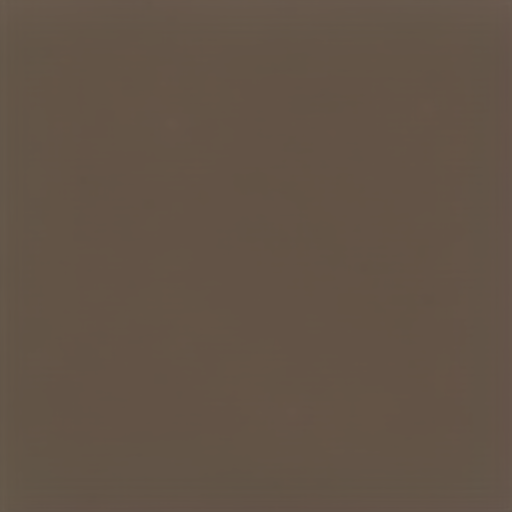

latent().shape =  torch.Size([1, 8192, 64, 64])
dec(latent()).shape =  torch.Size([1, 6, 512, 512])
out.shape =  torch.Size([1, 3, 512, 512])


In [6]:
# 【チェック】パラメータから画像生成
with torch.no_grad():
    out = unmap_pixels(torch.sigmoid(dec(latent())[:, :3].float()))
    displ(out.cpu()[0])

    print("latent().shape = ", latent().shape)
    print("dec(latent()).shape = ", dec(latent()).shape)
    print("out.shape = ", out.shape)

# 学習

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


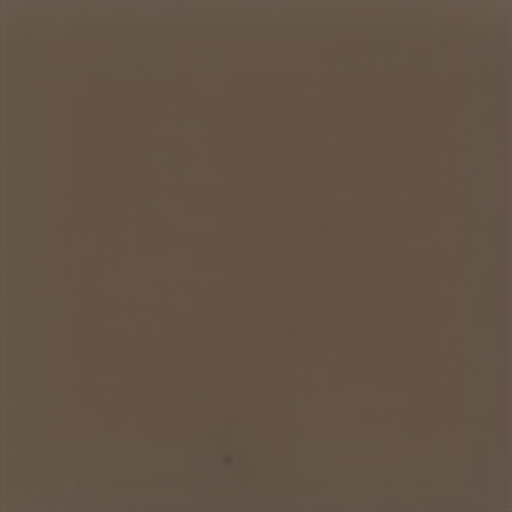

iter =  0
lr =  0.01005
tau_value =  2.0
loss =  -0.1903076171875




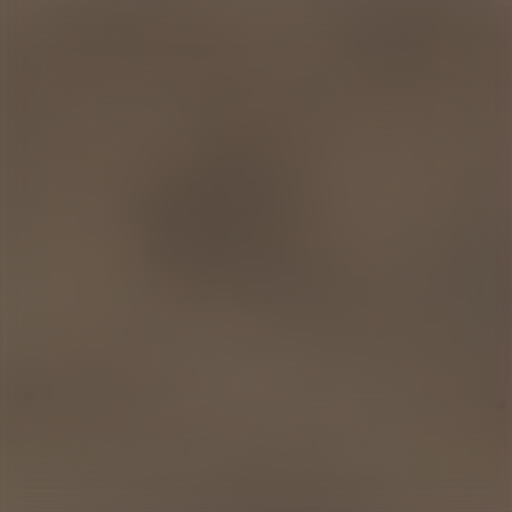

iter =  50
lr =  0.0128964194401004
tau_value =  2.0
loss =  -0.187744140625




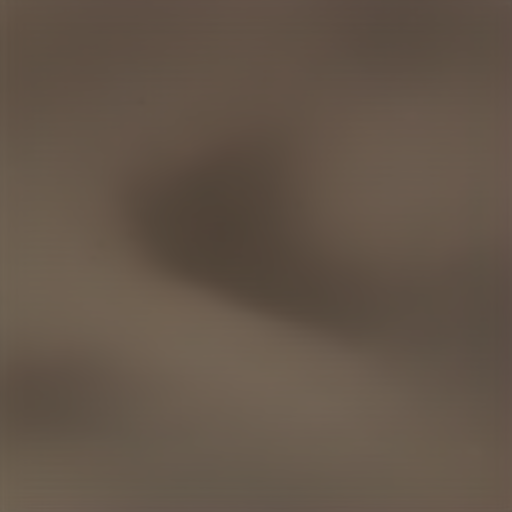

iter =  100
lr =  0.0165490183457711
tau_value =  2.0
loss =  -0.1976318359375




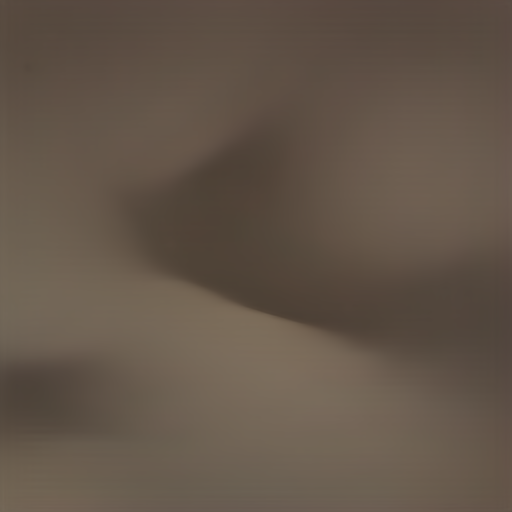

iter =  150
lr =  0.0212361275531324
tau_value =  2.0
loss =  -0.2154541015625




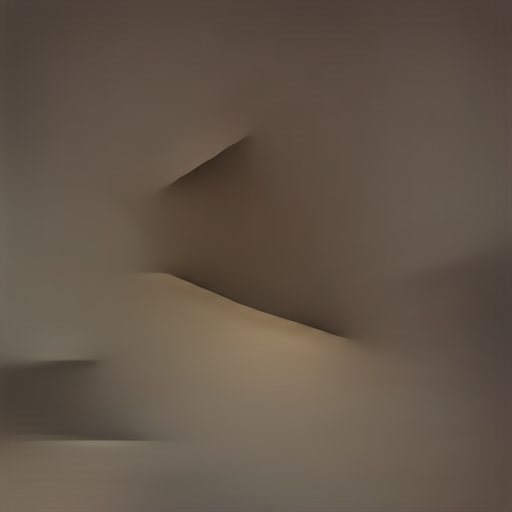

iter =  200
lr =  0.027250747085439654
tau_value =  2.0
loss =  -0.2491455078125




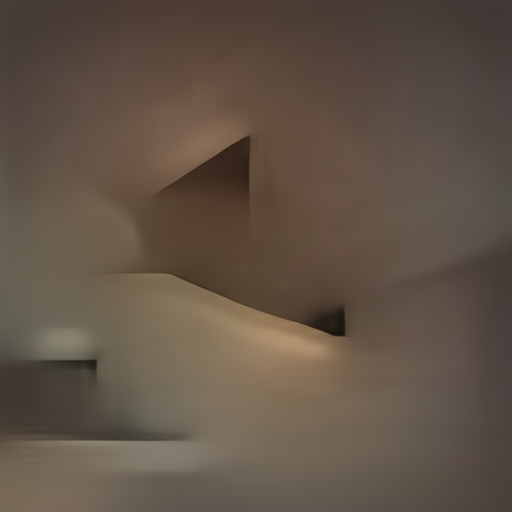

iter =  250
lr =  0.03496886213631078
tau_value =  2.0
loss =  -0.2841796875




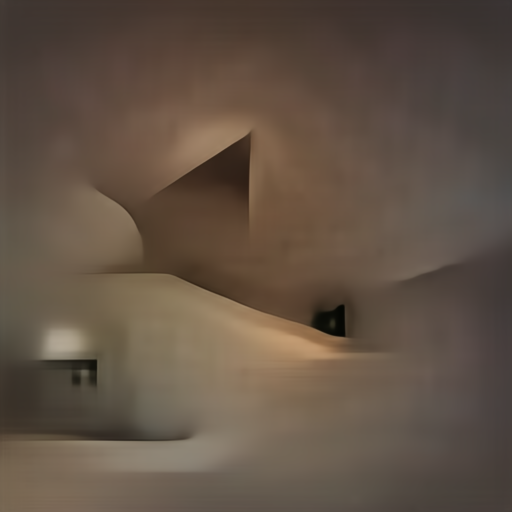

iter =  300
lr =  0.0448729466122298
tau_value =  2.0
loss =  -0.30126953125




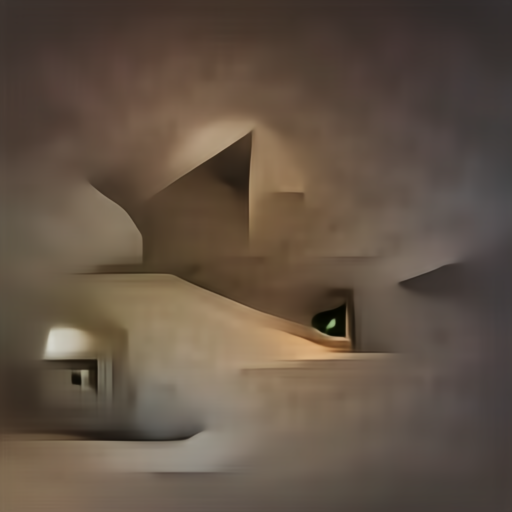

iter =  350
lr =  0.05758212348502963
tau_value =  2.0
loss =  -0.33544921875




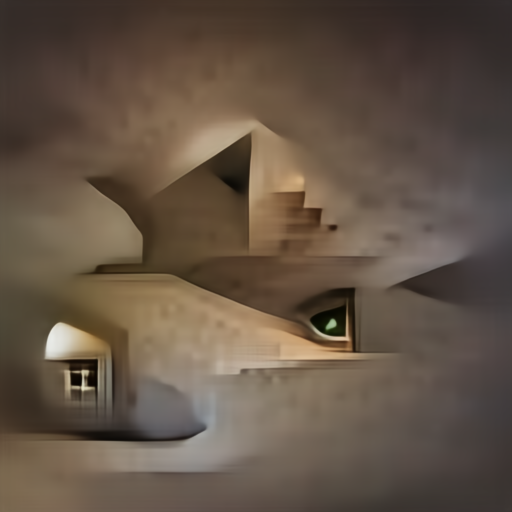

iter =  400
lr =  0.07389086733478589
tau_value =  2.0
loss =  -0.3544921875




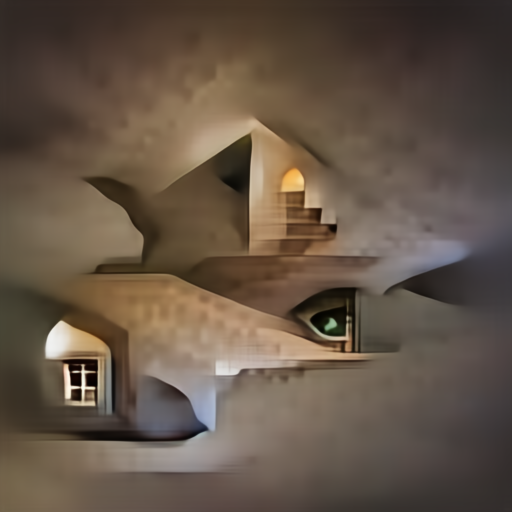

iter =  450
lr =  0.09481866845196141
tau_value =  2.0
loss =  -0.37255859375




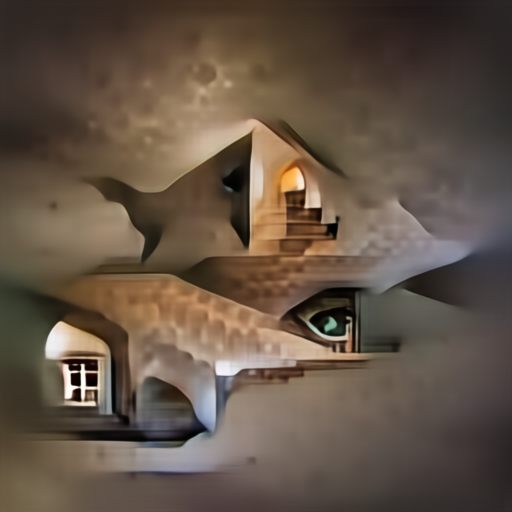

iter =  500
lr =  0.12
tau_value =  2.0
loss =  -0.381103515625




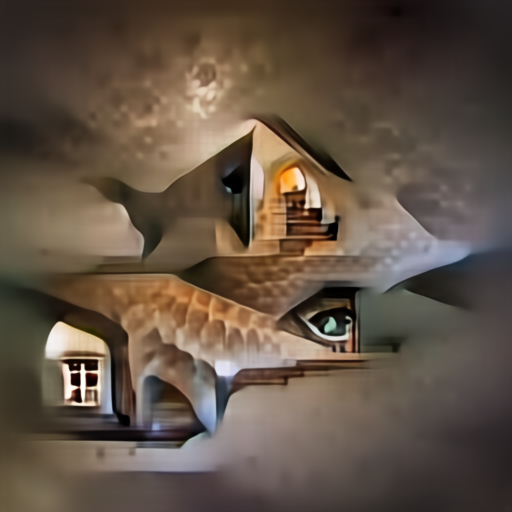

iter =  550
lr =  0.12
tau_value =  2.0
loss =  -0.396484375




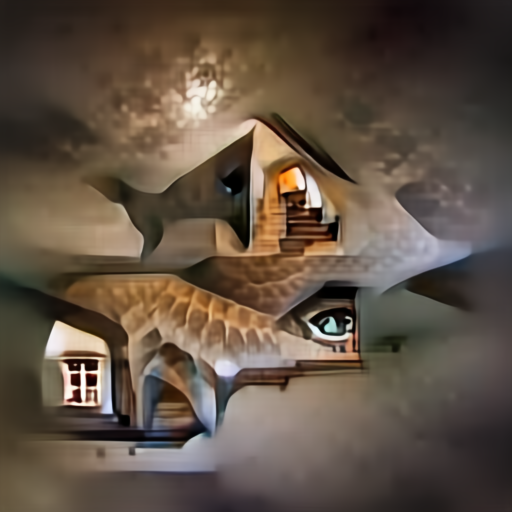

iter =  600
lr =  0.12
tau_value =  2.0
loss =  -0.40771484375




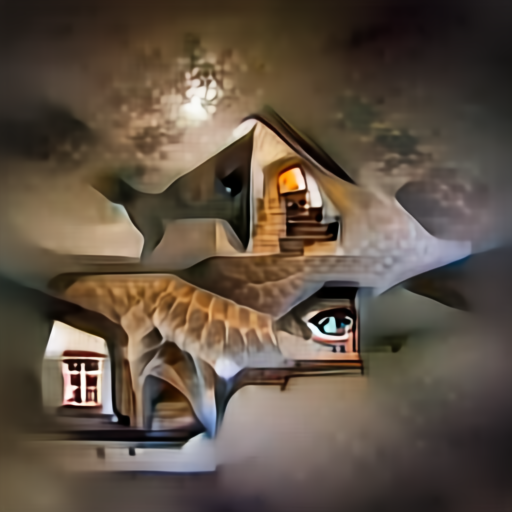

iter =  650
lr =  0.12
tau_value =  2.0
loss =  -0.3984375




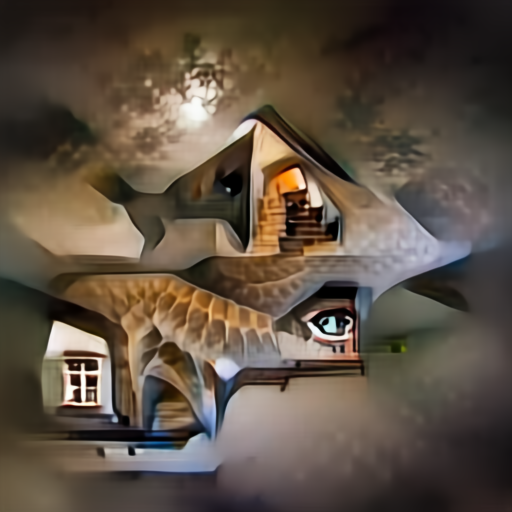

iter =  700
lr =  0.12
tau_value =  2.0
loss =  -0.418701171875




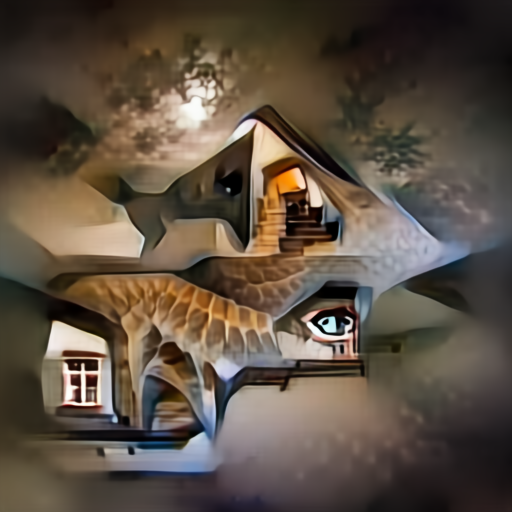

iter =  750
lr =  0.12
tau_value =  2.0
loss =  -0.419677734375




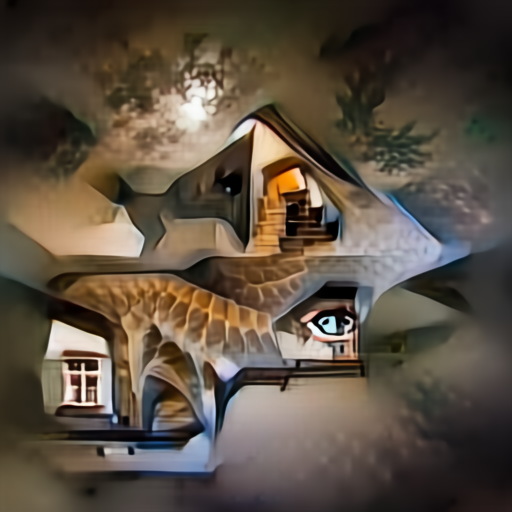

iter =  800
lr =  0.12
tau_value =  2.0
loss =  -0.408935546875




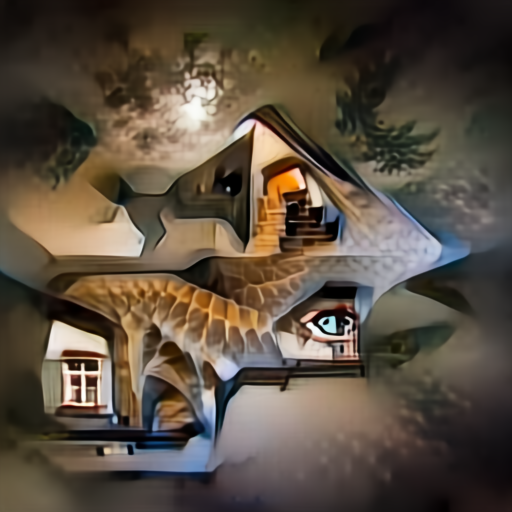

iter =  850
lr =  0.12
tau_value =  2.0
loss =  -0.409423828125




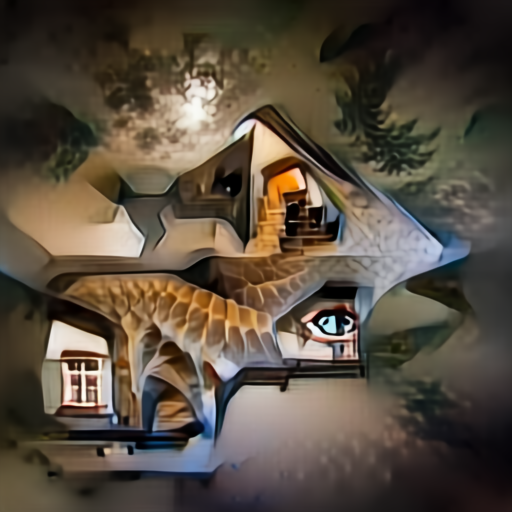

iter =  900
lr =  0.12
tau_value =  2.0
loss =  -0.42578125




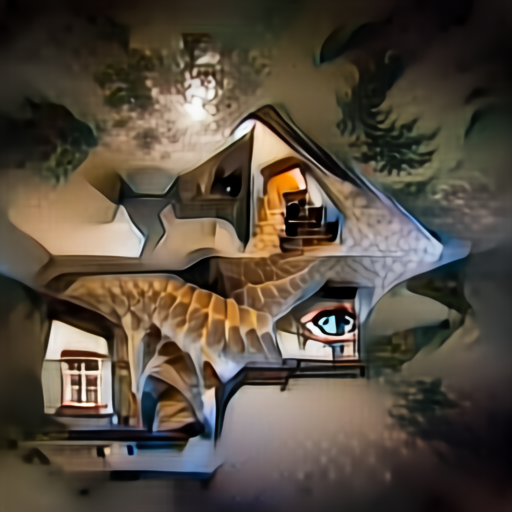

iter =  950
lr =  0.12
tau_value =  2.0
loss =  -0.4150390625




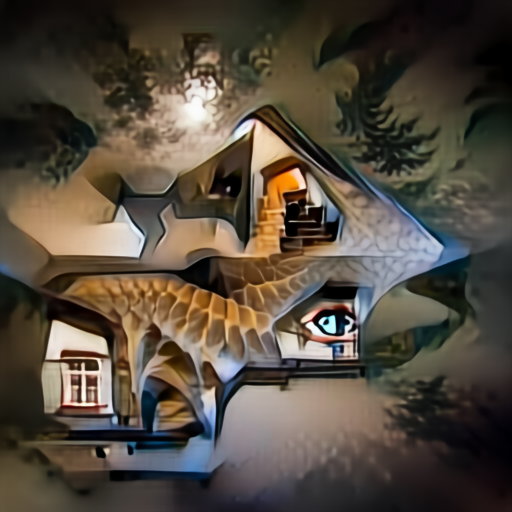

iter =  1000
lr =  0.12
tau_value =  2.0
loss =  -0.42529296875




In [7]:
# 学習ループ
for iteration in range(1001):

    # --- 順伝播 ---
    # パラメータから画像を生成
    out = unmap_pixels(torch.sigmoid(dec(latent())[:, :3].float()))
    # 画像をランダム切り出し・回転
    into = augment(out)
    # 画像を正規化
    into = nom((into))
    # 画像から特徴ベクトルを取得
    image_v = model.encode_image(into)
    # テキストと画像の特徴ベクトルのCOS類似度を計算
    loss = -torch.cosine_similarity(text_v, image_v).mean()

    # 逆伝播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 学習率の調整
    for g in optimizer.param_groups:
        g["lr"] = g["lr"] * 1.005
        g["lr"] = min(g["lr"], 0.12)

    # ログ表示
    if iteration % 50 == 0:
        with torch.no_grad():

            # 生成画像の表示・保存
            out = unmap_pixels(
                torch.sigmoid(dec(latent())[:, :3]).float()
            )  ###
            displ(out.cpu()[0])  ###

            # データ表示
            print("iter = ", iteration)
            for g in optimizer.param_groups:
                print("lr = ", g["lr"])
            print("tau_value = ", tau_value)
            print("loss = ", loss.item())
            print("\n")